In [ ]:
!pip install joblib
!pip install Flask


In [ ]:
# import libraries
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
train_data_path = '/content/drive/My Drive/dataset_folder/PM_train.txt'
test_data_path = '/content/drive/My Drive/dataset_folder/PM_test.txt'
truth_data_path = '/content/drive/My Drive/dataset_folder/PM_truth.txt'

train_df = pd.read_csv(train_data_path, sep = " ", header = None)
test_df = pd.read_csv(test_data_path, sep = " ", header = None)
truth_df = pd.read_csv(truth_data_path, sep = " ", header = None)
# dropping NaN columns
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

Mounted at /content/drive


In [ ]:
# column headers
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df.columns = train_df.columns
sensor_columns = [f's{i}' for i in range(1, 22)]



In [ ]:
# create RUL feature for training data
train_df['RUL'] = train_df.groupby('id')['cycle'].transform(lambda x: x.max() - x)

# normalizing cycles ran through for training and testing data
scaler = MinMaxScaler()
train_df['cycle_norm'] = scaler.fit_transform(train_df[['cycle']])
test_df['cycle_norm'] = scaler.fit_transform(test_df[['cycle']])

test_df[['id','cycle_norm']].head()

,id,cycle_norm
0,1,0.000000
1,1,0.003311
2,1,0.006623
3,1,0.009934
4,1,0.013245


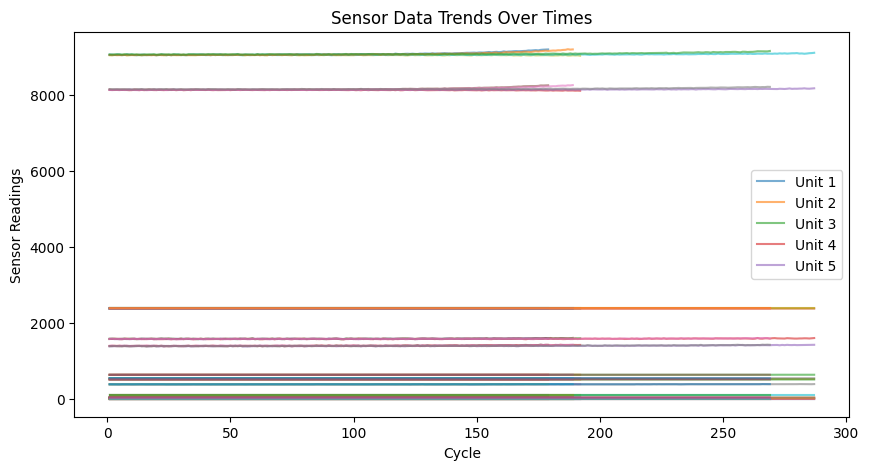

In [ ]:
# plotting sensor data trends over time for the first 5 units

unit_ids = train_df['id'].unique()[:5] #[1,2,3,4,5]

plt.figure(figsize=(10, 5))

for unit_id in unit_ids:
    unit_data = train_df[train_df['id'] == unit_id]
    for sensor in sensor_columns:
        plt.plot(unit_data['cycle'], unit_data[sensor], label=f'Unit {unit_id}', alpha=0.6)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel('Cycle')
plt.ylabel('Sensor Readings')
plt.title('Sensor Data Trends Over Times')
plt.show()

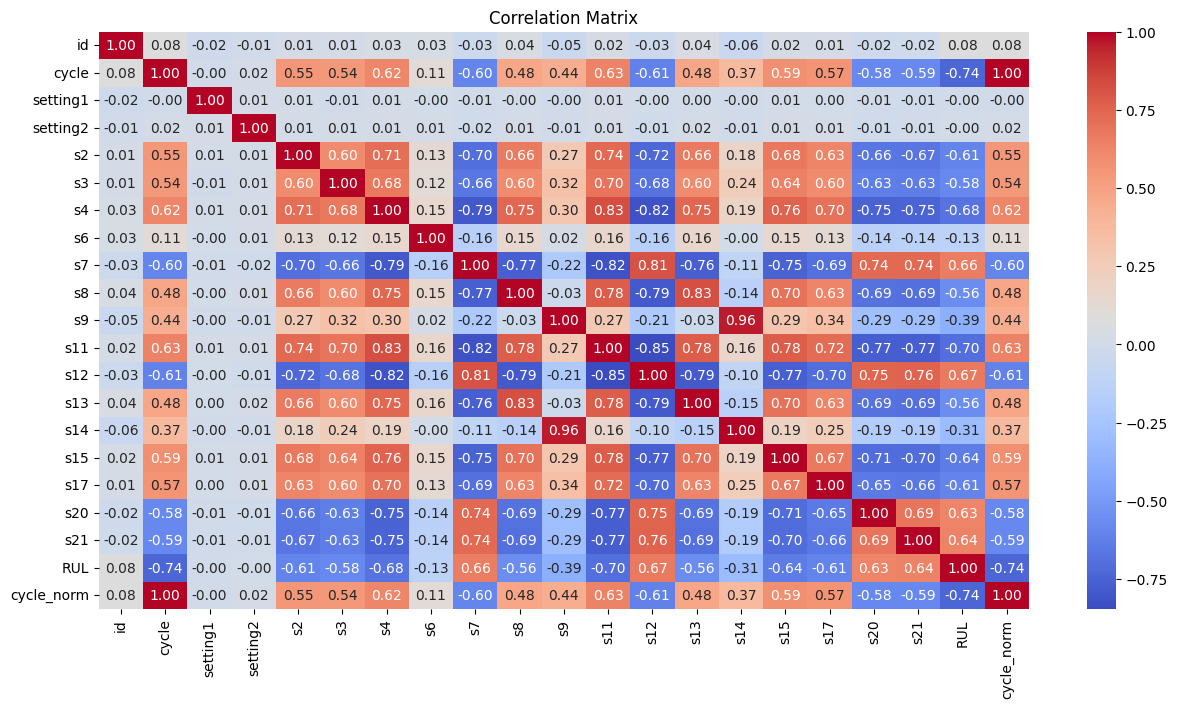

In [ ]:
# removing columns with no variance from the original dataset
no_variance_columns = [col for col in train_df.columns if train_df[col].nunique() == 1]

train_df = train_df.drop(columns=no_variance_columns)
test_df = test_df.drop(columns=no_variance_columns)

# correlation matrix
plt.figure(figsize=(15, 7.5))
correlation_matrix = train_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
sensor_col = {f's{i}' for i in range(1, 22)}
no_variance = set(no_variance_columns)
sensor_columns = sensor_col.difference(no_variance)

In [ ]:
# feature engineering
features = {}

window_size = 10
lag_steps = 5

for sensor in sensor_columns:
    # rolling window statistics
    features[f'{sensor}_rolling_mean'] = train_df.groupby('id')[sensor].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    features[f'{sensor}_rolling_std'] = train_df.groupby('id')[sensor].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())

    # exponentially weighted moving average
    features[f'{sensor}_ema'] = train_df.groupby('id')[sensor].transform(lambda x: x.ewm(span=window_size, min_periods=1).mean())

    # lag features
    for lag in range(1, lag_steps + 1):
        features[f'{sensor}_lag_{lag}'] = train_df.groupby('id')[sensor].shift(lag)


In [ ]:

features_df = pd.DataFrame(features)

# filling NaN values - forward/backward fill & interpolate
features_df.fillna(method='ffill', inplace=True)
features_df.fillna(method='bfill', inplace=True)
features_df.interpolate(method='linear', inplace=True)

features_df.head()

<ipython-input-11-930682dbc784>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df.fillna(method='ffill', inplace=True)
<ipython-input-11-930682dbc784>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df.fillna(method='bfill', inplace=True)


,s7_rolling_mean,s7_rolling_std,s7_ema,s7_lag_1,s7_lag_2,s7_lag_3,s7_lag_4,s7_lag_5,s3_rolling_mean,s3_rolling_std,...,s9_lag_4,s9_lag_5,s15_rolling_mean,s15_rolling_std,s15_ema,s15_lag_1,s15_lag_2,s15_lag_3,s15_lag_4,s15_lag_5
0,554.360000,0.431335,554.360000,554.36,554.36,554.36,554.36,554.36,1589.700000,1.499066,...,9046.19,9046.19,8.419500,0.008697,8.419500,8.4195,8.4195,8.4195,8.4195,8.4195
1,554.055000,0.431335,554.024500,554.36,554.36,554.36,554.36,554.36,1590.760000,1.499066,...,9046.19,9046.19,8.425650,0.008697,8.426265,8.4195,8.4195,8.4195,8.4195,8.4195
2,554.123333,0.327159,554.119169,553.75,554.36,554.36,554.36,554.36,1589.836667,1.918654,...,9046.19,9046.19,8.423033,0.007640,8.422862,8.4318,8.4195,8.4195,8.4195,8.4195
3,554.205000,0.313103,554.228163,554.26,553.75,554.36,554.36,554.36,1588.075000,3.855909,...,9046.19,9046.19,8.409325,0.028117,8.404853,8.4178,8.4318,8.4195,8.4195,8.4195
4,554.164000,0.286234,554.162664,554.45,554.26,553.75,554.36,554.36,1587.030000,4.075678,...,9046.19,9046.19,8.413340,0.025953,8.411900,8.3682,8.4178,8.4318,8.4195,8.4195


In [ ]:
# formatting the training data

pd.set_option('display.max_columns', None)
train_combined = pd.DataFrame()

train_combined = pd.concat([train_combined, train_df[['setting1', 'setting2']]], axis=1)
sensor_columns = list(sensor_columns)
train_combined = pd.concat([train_df[['setting1', 'setting2']], train_df[sensor_columns], train_df[['cycle_norm']], features_df, train_df[['RUL']]], axis=1)
test_combined = pd.concat([test_df[['setting1', 'setting2']], test_df[sensor_columns], test_df[['cycle_norm']], features_df], axis=1)

In [ ]:
# normalizing the combined training and test data using MinMaxScaler
train_combined_normalized = scaler.fit_transform(train_combined)
train_combined_normalized = pd.DataFrame(train_combined_normalized, columns=train_combined.columns)

test_combined_normalized = scaler.fit_transform(test_combined)
test_combined_normalized = pd.DataFrame(test_combined_normalized, columns=test_combined.columns)


test_combined_normalized.head()

,setting1,setting2,s7,s3,s13,s21,s11,s12,s4,s8,s20,s17,s14,s6,s2,s9,s15,cycle_norm,s7_rolling_mean,s7_rolling_std,s7_ema,s7_lag_1,s7_lag_2,s7_lag_3,s7_lag_4,s7_lag_5,s3_rolling_mean,s3_rolling_std,s3_ema,s3_lag_1,s3_lag_2,s3_lag_3,s3_lag_4,s3_lag_5,s13_rolling_mean,s13_rolling_std,s13_ema,s13_lag_1,s13_lag_2,s13_lag_3,s13_lag_4,s13_lag_5,s21_rolling_mean,s21_rolling_std,s21_ema,s21_lag_1,s21_lag_2,s21_lag_3,s21_lag_4,s21_lag_5,s11_rolling_mean,s11_rolling_std,s11_ema,s11_lag_1,s11_lag_2,s11_lag_3,s11_lag_4,s11_lag_5,s12_rolling_mean,s12_rolling_std,s12_ema,s12_lag_1,s12_lag_2,s12_lag_3,s12_lag_4,s12_lag_5,s4_rolling_mean,s4_rolling_std,s4_ema,s4_lag_1,s4_lag_2,s4_lag_3,s4_lag_4,s4_lag_5,s8_rolling_mean,s8_rolling_std,s8_ema,s8_lag_1,s8_lag_2,s8_lag_3,s8_lag_4,s8_lag_5,s20_rolling_mean,s20_rolling_std,s20_ema,s20_lag_1,s20_lag_2,s20_lag_3,s20_lag_4,s20_lag_5,s17_rolling_mean,s17_rolling_std,s17_ema,s17_lag_1,s17_lag_2,s17_lag_3,s17_lag_4,s17_lag_5,s14_rolling_mean,s14_rolling_std,s14_ema,s14_lag_1,s14_lag_2,s14_lag_3,s14_lag_4,s14_lag_5,s6_rolling_mean,s6_rolling_std,s6_ema,s6_lag_1,s6_lag_2,s6_lag_3,s6_lag_4,s6_lag_5,s2_rolling_mean,s2_rolling_std,s2_ema,s2_lag_1,s2_lag_2,s2_lag_3,s2_lag_4,s2_lag_5,s9_rolling_mean,s9_rolling_std,s9_ema,s9_lag_1,s9_lag_2,s9_lag_3,s9_lag_4,s9_lag_5,s15_rolling_mean,s15_rolling_std,s15_ema,s15_lag_1,s15_lag_2,s15_lag_3,s15_lag_4,s15_lag_5
0,0.65625,0.692308,0.608871,0.421968,0.325581,0.620099,0.273973,0.534247,0.282214,0.365854,0.500000,0.375,0.152259,1.0,0.596215,0.196475,0.347076,0.000000,0.762409,0.312200,0.766807,0.726248,0.726248,0.726248,0.702797,0.702797,0.496532,0.119454,0.495953,0.406802,0.406802,0.406802,0.406802,0.406802,0.229008,0.199536,0.231062,0.229508,0.274510,0.285714,0.291667,0.291667,0.767143,0.016623,0.768934,0.724662,0.724662,0.724662,0.724662,0.724662,0.429253,0.058824,0.425668,0.380368,0.380368,0.397436,0.413333,0.413333,0.637767,0.488189,0.640978,0.633262,0.633262,0.611738,0.59434,0.59434,0.306544,0.115653,0.307035,0.326164,0.326164,0.326164,0.328206,0.328206,0.357143,0.078140,0.361307,0.285714,0.355556,0.355556,0.363636,0.363636,0.765101,0.130435,0.767506,0.713178,0.713178,0.713178,0.713178,0.713178,0.281690,0.000000,0.287032,0.333333,0.333333,0.333333,0.363636,0.363636,0.202531,0.379097,0.200888,0.205395,0.214984,0.221395,0.223959,0.229623,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.154553,0.374116,0.152747,0.183735,0.185410,0.185410,0.18541,0.18541,0.094330,0.094013,0.091366,0.119393,0.122822,0.126716,0.126716,0.129077,0.446312,0.131324,0.446382,0.363986,0.363986,0.363986,0.389461,0.389461
1,0.34375,0.230769,0.800403,0.504025,0.395349,0.645718,0.479452,0.634703,0.225240,0.292683,0.645455,0.500,0.277907,1.0,0.182965,0.229042,0.227709,0.003311,0.690661,0.312200,0.689345,0.726248,0.726248,0.726248,0.702797,0.702797,0.528086,0.119454,0.530622,0.406802,0.406802,0.406802,0.406802,0.406802,0.292621,0.199536,0.301665,0.229508,0.274510,0.285714,0.291667,0.291667,0.771764,0.016623,0.773978,0.724662,0.724662,0.724662,0.724662,0.724662,0.437202,0.058824,0.434339,0.380368,0.380368,0.397436,0.413333,0.413333,0.729810,0.488189,0.741327,0.633262,0.633262,0.611738,0.59434,0.59434,0.335992,0.115653,0.339481,0.326164,0.326164,0.326164,0.328206,0.328206,0.331633,0.078140,0.332918,0.285714,0.355556,0.355556,0.363636,0.363636,0.731544,0.130435,0.730972,0.713178,0.713178,0.713178,0.713178,0.713178,0.281690,0.000000,0.287032,0.333333,0.333333,0.333333,0.363636,0.363636,0.181095,0.379097,0.177575,0.205395,0.214984,0.221395,0.223959,0.229623,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.223475,0.374116,0.227676,0.183735,0.185410,0.185410,0.18541,0.18541,0.088612,0.094013,0.085096,0.119393,0.122822,0.126716,0.126716,0.129077,0.477084,0.131324,0.480236,0.363986,0.363986,0.363986,0.389461,0.389461
2,0.53125,0.538462,0.651210,0.464814,0.325581,0.681104,0.479452,0.591324,0.346130,0.390244,0.700000,0.500,0.192892,1.0,0.419558,0.248506,0.533557,0.006623,0.706736,0.234241,0.711203,0.628019,0.726248,0.726248,0.702797,0.702797

In [ ]:
 # creating sequences of data for the LSTM model

 def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:i+seq_length, :-1]  # All columns except RUL
        y = data.iloc[i+seq_length, -1]
        xs.append(x.values)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 50

X, y = create_sequences(train_combined_normalized, SEQ_LENGTH)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(16464, 50, 138) (4117, 50, 138) (16464,) (4117,)


In [ ]:
# lstm implementation

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 100)             │          95,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,851 (491.61 KB)

 Trainable params: 125,851 (491.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=14, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/14
258/258 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.0479 - val_loss: 0.0143
Epoch 2/14
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0165 - val_loss: 0.0140
Epoch 3/14
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0146 - val_loss: 0.0114
Epoch 4/14
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0135 - val_loss: 0.0107
Epoch 5/14
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0126 - val_loss: 0.0101
Epoch 6/14
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0117 - val_loss: 0.0094
Epoch 7/14
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0107 - val_loss: 0.0092
Epoch 8/14
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0110 - val_loss: 0.0094
Epoch 9/14
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0096 - val_loss: 0.0086
Epoch 10/14
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0100 - val_loss: 0.0095
Epoch 11/14
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 12/14
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11m

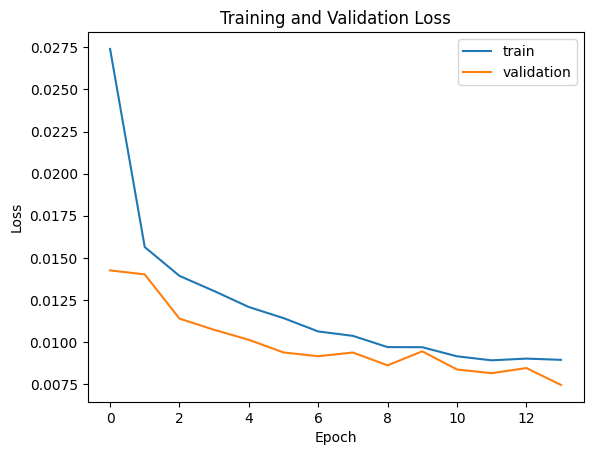

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Squared Error: 0.007454630453942751
Mean Absolute Error: 0.05810107204981018


In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


y_pred = model.predict(X_val)


# error metrics
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

In [ ]:
# define the adjusted create_sequences function for test data
def create_sequences_for_test(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:i+seq_length]  # use all columns
        xs.append(x.values)
    return np.array(xs)


SEQ_LENGTH = 50
X_test = create_sequences_for_test(test_combined_normalized, SEQ_LENGTH)

In [ ]:
#inverting the normalized predicted RUL data

y_pred_test = model.predict(X_test)
rul_scaler = MinMaxScaler()
train_rul_normalized = rul_scaler.fit_transform(train_df[['RUL']])
y_pred_test = rul_scaler.inverse_transform(y_pred_test)

644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


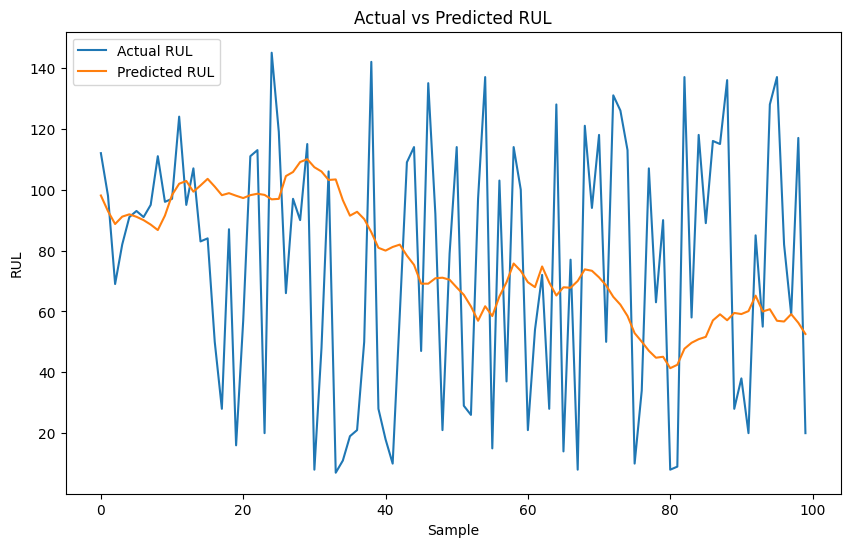

In [ ]:
truth_df.columns = ['RUL']
actual_rul = truth_df['RUL'].values

# Align the length of y_pred_test with truth_df
y_pred_test = y_pred_test[:len(actual_rul)]

# Plot the predicted RUL values from the model and the actual RUL values from truth_df
plt.figure(figsize=(10, 6))
plt.plot(actual_rul, label='Actual RUL')
plt.plot(y_pred_test, label='Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.xlabel('Sample')
plt.ylabel('RUL')
plt.legend()
plt.show()